In [2]:
import mne
raw = mne.io.read_raw_edf("dataset/chb01_03.edf")
raw.load_data()
normal = raw.copy().crop(30, 60)
seizure = raw.copy().crop(3000, 3030)

Extracting EDF parameters from c:\Users\angus\Documents\cs408-eeg-python\dataset\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\angus\AppData\Local\Temp\ipykernel_12312\3666628031.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("dataset/chb01_03.edf")


Preprocessing step from `preprocessing-frequency-bands.ipynb`.

In [3]:
normal = normal.notch_filter(60, verbose=False)
seizure = seizure.notch_filter(60, verbose=False)

iter_freqs = [("Delta", 0.5, 3), ("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 25), ("Gamma", 30, 45)]
normal_bands: dict[str, (mne.io.Raw, float, float)] = {}
seizure_bands: dict[str, (mne.io.Raw, float, float)] = {}
for band, lo, hi in iter_freqs:
    print("filtering", band)
    normal_out = normal.copy()
    seizure_out = seizure.copy()
    normal_bands[band] = (normal_out.filter(l_freq=lo, h_freq=hi, method="fir", n_jobs=1, verbose=False), lo, hi)
    seizure_bands[band] = (seizure_out.filter(l_freq=lo, h_freq=hi, method="fir", n_jobs=1, verbose=False), lo, hi)

filtering Delta
filtering Theta
filtering Alpha
filtering Beta
filtering Gamma


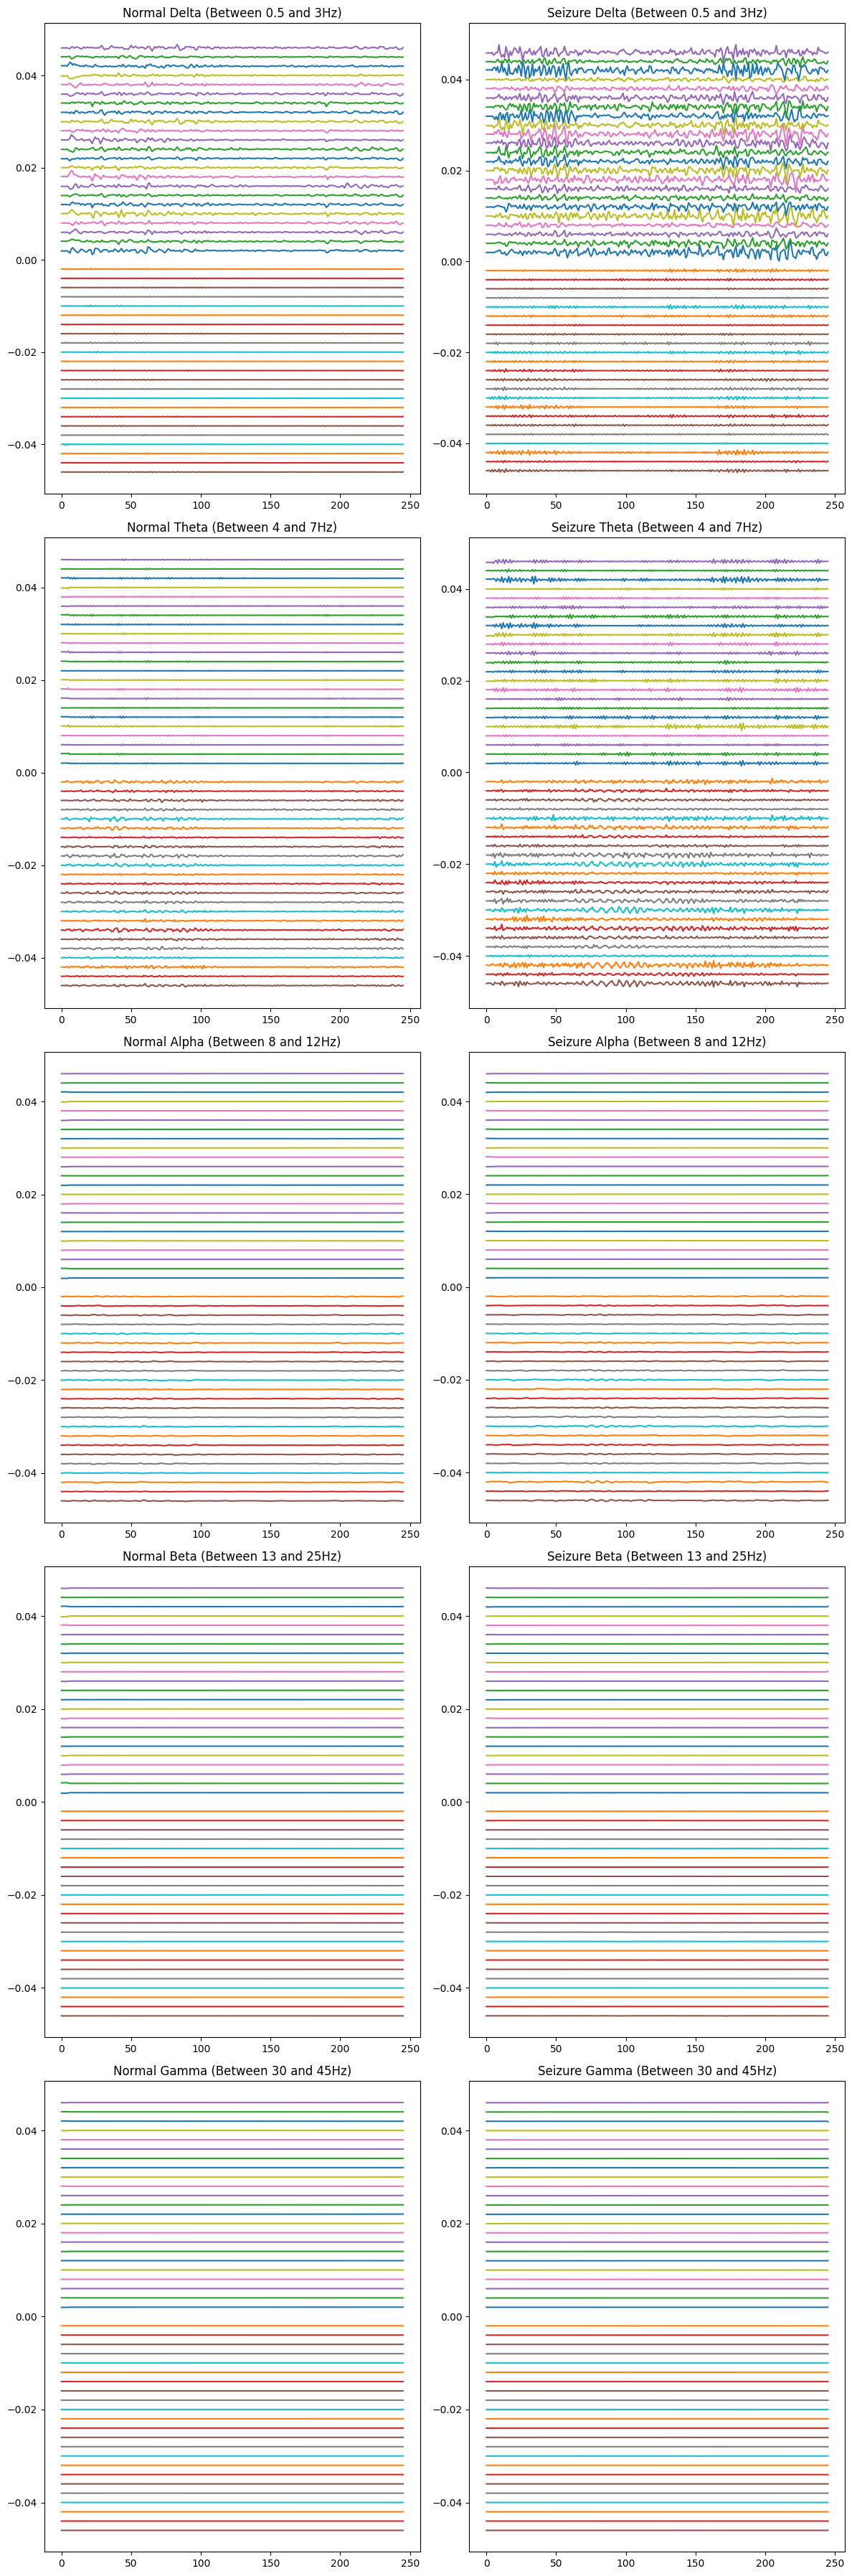

In [5]:
import pywt
import matplotlib.pyplot as plt

wavelet = "db4"

na = []
nd = []
sa = []
sd = []

fig, axs = plt.subplots(len(normal_bands.keys()), 2, figsize=(12,36))
for i, (band, (data, lo, hi)) in enumerate(normal_bands.items()):
    data, times = data.get_data(return_times=True)
    for sensor_idx in range(data.shape[0]):
        na_c, nd_c, _, _, _, _ = pywt.wavedec(data[sensor_idx], wavelet, level=5)
        na.append(na_c)
        nd.append(nd_c)
        axs[i][0].plot(na_c + 0.002*(sensor_idx+1), label="Normal Approximation")
        axs[i][0].plot(nd_c - 0.002*(sensor_idx+1), label="Normal Detail")
    axs[i][0].set_title(f"Normal {band} (Between {lo} and {hi}Hz)")

for i, (band, (data, lo, hi)) in enumerate(seizure_bands.items()):
    data, times = data.get_data(return_times=True)
    for sensor_idx in range(data.shape[0]):
        sa_c, sd_c, _, _, _, _ = pywt.wavedec(data[sensor_idx], wavelet, level=5)
        sa.append(sa_c)
        sd.append(sd_c)
        axs[i][1].plot(sa_c + 0.002*(sensor_idx+1), label="Normal Approximation")
        axs[i][1].plot(sd_c - 0.002*(sensor_idx+1), label="Normal Detail")
    axs[i][1].set_title(f"Seizure {band} (Between {lo} and {hi}Hz)")



plt.tight_layout()
plt.show()

In [8]:
import numpy as np

for i in range(0, len(na)):
    print(np.mean(sa[i]), np.median(sa[i]), np.std(sa[i]))
    break

-1.8814450222214976e-06 1.0604298866869584e-05 0.0006201754028990787
